# Python Scikit-Learn for Multi-class Classification of Plumbing Products

In [265]:
from platform import python_version
print(python_version())

3.6.8


## What We're Covering Today 
- Python for Machine Learning 
- Scikit Learn Library 
- Jupyter Notebooks 
- Statistical Algorithms for Classification Problems
- Tips and Tricks for developing models within Python

## Machine Learning
- Machine Learning has two essential problems: supervised (known class) and unsupervised (unknown class).  For those familiar with statistical methods: supervised has a dependent variable, unsupervised is for things like clustering. 
- Many of the toosl and methods used in machine learning are based statistical methods and algorithms that have been in use for more than a centruy.
    - Linear Regression: predicting a continuous variable
    - Logistic Regression: predicting a binary variable
- Neural Networks are "essentially" layered logistic regression problems. 

# Define the Business Problem 

#### Summary 
Trade Service utilizes a classification system known as LEAF class to ascribe attributes to individual products.  When a LEAF class is known, certain descriptive attributes which are important to customers can be automatically applied to the product.  

#### Challenge
There are approximately 2.1 million plumbing products in the Trade Service database.  Currently, only 25% have been correctly labeled.  The labeling process currently requires a team of humans to manually inspect the product, understand what is is, and then manualy asign what they believe to be the most appropriate LEAF class.  Since humans are currently using the manufacturer's description to apply the correct classification, we suspect that we could use Machine Learning to replicate an automate the process using Natural Language Processing.  

#### Goal 
develop a machine learning algorithm that can successfull learn how to categorize products based on their original manufacturer description into the correct LEAF class with better baseline accuracy. 

#### Business Importance 
A successful alogorithm has the potential to significantly reduce costs to the company by reducing the labor costs associated with manually classifying products, and frees up resources for other tasks.  

#### Statistical Approach
Most Multiclass tutorials only give examples of multi-class problems involving 5 - 10 classes.  Here we have a real-world scenario involving hundreds, and potentially thousands of classes. 

Utilize Python's Scikit Learn Library to develop a Natural-Language-based Multi-Class Classification Algorithm to classify the plumbing products, optimize the algorithm, and determine low-accuracy classes which require additional training data.  Split the data into training and test sets to provide inferential statistics for applying the alogrithm to the unlabeled data set. Algorithms that are ideal for Multi-Class, Natural Language problems:
- Multinomial Naive Bayes
- Support Vector Machines
- Multinomial Logistic Regression (Polynomial Regression) 
- Neural Network (maybe...) 
   

#### Known problems 
- The dataset suffers from extreme class in-balance, which needs to be corrected prior to processing the data.  
- This type of multi-class problem falls within the topic of "extreme multiclass" because of the very large number of classes which are considered.
- Under-sampling: Remove samples from over-represented classes ; use this if you have huge dataset




In [295]:
# import the necessary Python libraries.  Some of these are not really going to be used.  However, we import them in 
# the case that we want to do further experimentation
import pandas as pd        #this is required for data mamipulation
import numpy as np         #this is required for data manipulation
import sklearn as sk       #this is required for Random Forest
import random              #this is required to randomize the data set
import nltk                #this is required for natural language processing

#these are the SciKit Learn Libraries which are needed to develop the Multi-class Classification algorithm
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import decomposition, ensemble
from sklearn.feature_extraction.text import CountVectorizer  #for natural language processing
from sklearn.feature_extraction.text import TfidfVectorizer  #for natural language processing 
from sklearn.model_selection import train_test_split         #for train/test splitting
#from sklearn.pipeline import Pipeline                        #to leverage Scikit Learn's pipeline feature

#these are Scikit alogirhtm libraries to try different classification libraries 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import class_weight
from sklearn.utils import resample                          #for resampling needed for imbalanced classes 

#import plotting function 
import matplotlib as plt
import seaborn as sns


import xlwt
import xlsxwriter
from nltk.stem.lancaster import LancasterStemmer

# Prepare and Clean the Dataset

import the data that has been extracted from the data wareshouse. Drop missing values and check the number of observations. 

In [230]:
df = pd.read_csv("c:/Users/rclukey/Google Drive/inventory_class/all_plumbing_clean.csv")
df.dropna(inplace=True)  #we want to drop the missing values within the same dataframe.
len(df)  #check the length of the dataframe

502839

In [255]:
df.head(10)  #check what our dataset looks like 

,Order,LEAF_CLASS_ID,LEAF_CLASS_NAME,PRODUCT_NAME,DESCRIPT
0,1,0,Remote Controls,REMOTE CONTROL,SPCTRM SRT-ORB REMOTE CONTROL
1,2,0,Remote Controls,REMOTE CONTROL,SPCTRM SRC-PC REMOTE CONTROL
2,3,0,Remote Controls,REMOTE CONTROL,WOLFST W660-0010B REMOTE CONTROL
3,4,0,Remote Controls,REMOTE CONTROL,SPCTRM SRT-PC REMOTE CONTROL
4,248025,0,Remote Controls,REMOTE CONTROL,SPCTRM SRT-PC REMOTE CONTROL
5,248026,0,Remote Controls,REMOTE CONTROL,SPCTRM SRT-ORB REMOTE CONTROL
6,248027,0,Remote Controls,REMOTE CONTROL,SPCTRM SRC-SN REMOTE CONTROL
7,248028,0,Remote Controls,REMOTE CONTROL,SPCTRM SRC-PC REMOTE CONTROL
8,248029,0,Remote Controls,REMOTE CONTROL,SPCTRM SRT-SN REMOTE CONTROL
9,248030,0,Remote Controls,REMOTE CONTROL,WOLFST W660-0010B REMOTE CONTROL


# Basic Data Description and Setup

In [232]:
# Find out how many classes we have and the counts for each class.  This is necessary to help understand class imbalance 
count_LC = df.groupby('LEAF_CLASS_ID').aggregate(np.count_nonzero).sort_values(['Order'],ascending=False)
len(count_LC)

686

With 686 classes, we need to be careful about class imbalance issues as many of the classes have very low counts, which will affect the performance of the classification algortihm

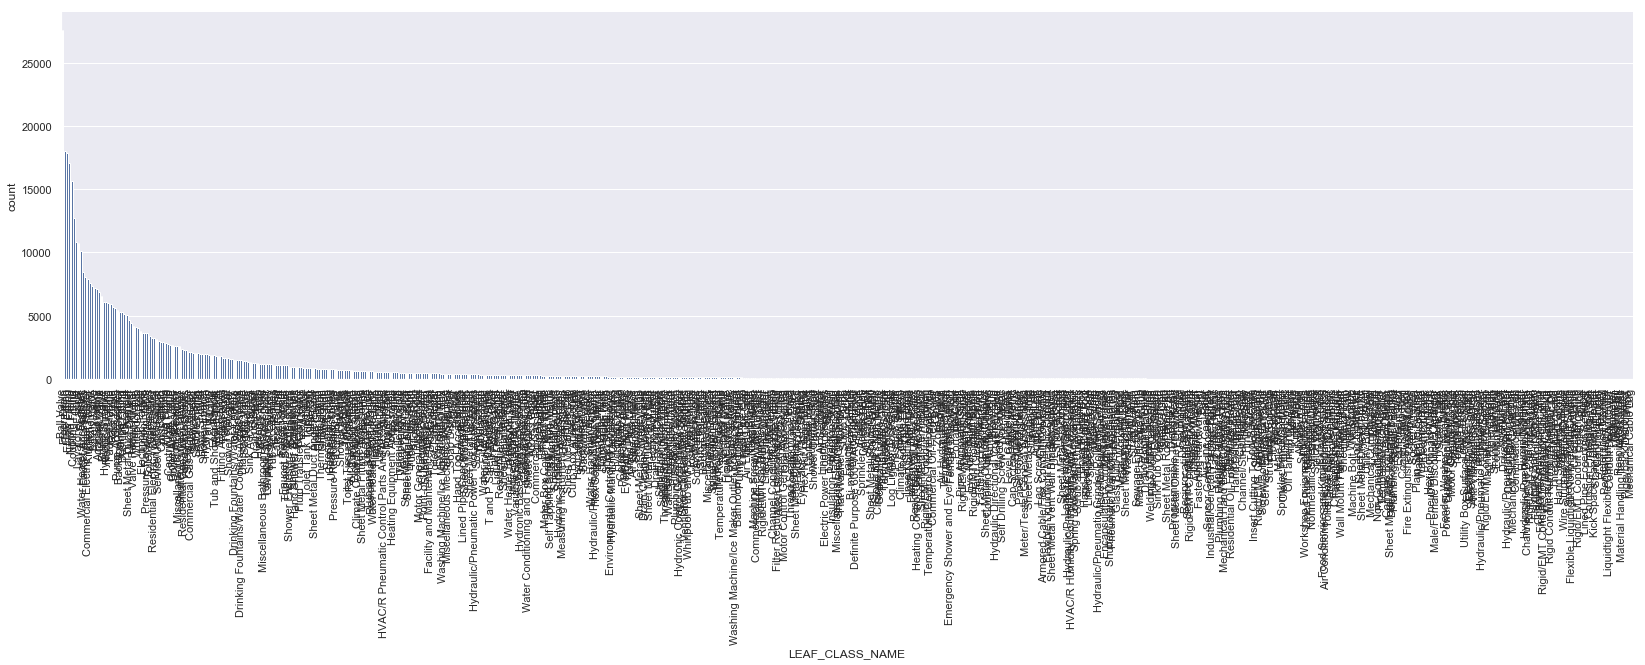

In [40]:
#ax = sns.countplot(x="LEAF_CLASS_NAME", data=df)
g = sns.catplot("LEAF_CLASS_NAME", data=df, order = df['LEAF_CLASS_NAME'].value_counts().index,height = 6,aspect=4, kind="count", color="b")
g.set_xticklabels(rotation=90)

## Dealing with Class Imbalance 
class imbalance can be very problematic in classification problems.  In some instances, it is actually beneficial to see how the algorithm treats low frequency classes.  In most cases, we'll want to use use techniques to "adjust" for the frequency bias.  Scikit Learn has a number of options for this; most algorithms come with with "class_weight" option to specificy that the dataset is imbalanced.

1. remove low-sample classes, or group them together into their own class
2. Use Scikit's built-in tools for dealing with class imbalance

## Constructing the Classification Model

we're going to build and compare two models: Stochastic Gradient Descent and Multinomial Naive Bayes.  Both alogorithms have been demonstrated to perform will on Natural Language Machine Learning tasks, and both have pros and cons.   

http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf

### Naive Bayes
this algorithm is probablistic and relies on Bayes Theorem in determining the probability of class assignment.  It is "naive" because it assumes each feature is independent; it does not consider the relationship between features. 

### Support Vector Machine
In our implementation, we're using Stochastic Gradient Descent, which basically makes this a multinomial version of Logistic Regression. 


### Define variables of interest and prepare the sample
the indepentend variable (or feature set) is going to be the vector of words from our product descriptions.  The dependent variable is going to be the LEAF Class ID label for each products.  Based on the previous pre-processing, we have approximately 528 labels supported by 502839 observations, which is nearly 1000:1 - however, recall that the classes are imbalanced. 

In the code below, we're doing the following: 
- regrouping low frequency classes into a 



In [266]:
df.LEAF_CLASS_ID = df.LEAF_CLASS_ID.where(df.groupby('LEAF_CLASS_ID')['LEAF_CLASS_ID'].transform('count') > 100, 0)
df_s = df.sample(n=35000)

In [248]:
df_new = df.groupby(['LEAF_CLASS_ID']).count().sort_values(['Order'],ascending=False)
df_new

,Order,LEAF_CLASS_NAME,PRODUCT_NAME,DESCRIPT
LEAF_CLASS_ID,,,,
4279,27603,27603,27603,27603
4678,18022,18022,18022,18022
4352,17880,17880,17880,17880
4342,17073,17073,17073,17073
4348,15658,15658,15658,15658
4340,12680,12680,12680,12680
0,11616,11616,11616,11616
4952,10799,10799,10799,10799
4770,10769,10769,10769,10769


In [294]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline


## Train / Test Split (~30% Hold-out Sample) 
For training ML algoirthms it is important to validate the algorithm on data that hasn't been seen by the algorithm.  We typically use a hold-out sample of about 30% of the sample.  Once the algorithm has been trained, we test it on the hold-out sample to see the level of accuracy it achieves.  

In [291]:
y = df['LEAF_CLASS_ID']  #dependent variable set
x = df['DESCRIPT']       #feature variable set

In [296]:
#this splits the data into train and test sets - a common practice in machine learning is 
#to split the sample 70/30 (70% training, 30% validation)

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(x, y, test_size=0.30, stratify=y)

## Parameter Tuning via GridSearch
for Stochastic Gradient Descent it is important to tune the hyper-parameters of the algorithm.  Hyper-parameters are attributes that control how the alogirthm treats the data.  

In [261]:
from sklearn.model_selection import GridSearchCV
sgdclf = SGDClassifier(random_state=42, class_weight='balanced',alpha=.0001)

tv = TfidfVectorizer(stop_words='english', sublinear_tf=True, strip_accents='unicode', analyzer='char', 
                              token_pattern=r'\w{2,}', max_df=.25, ngram_range=(1,3), max_features=500)
tvx = tv.fit_transform(x)

tv_train_x, tv_valid_x, train_y, valid_y = model_selection.train_test_split(tvx, y, test_size=0.3, stratify=y)

## Plot the Change in Accuracy at Different Levels of Alpha

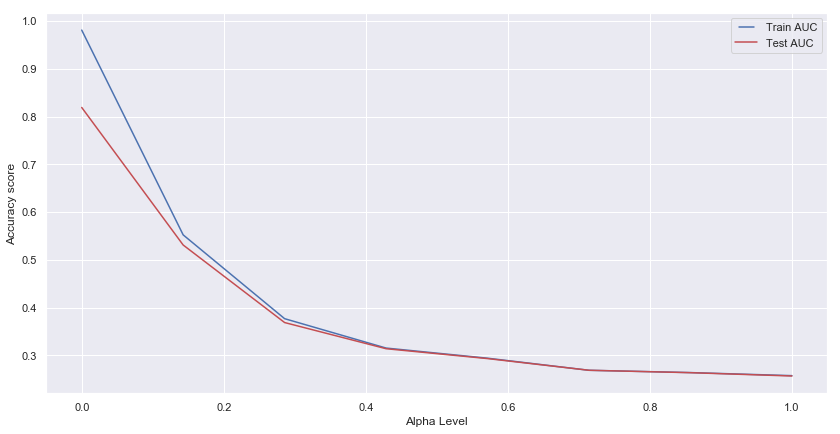

In [262]:
#tv_train_x, tv_valid_x, train_y, valid_y = model_selection.train_test_split(tvx, y, test_size=0.3, stratify=y)
import matplotlib.pyplot as plt
alpha = np.linspace(1, .000001, 8, endpoint=True)
train_results = []
test_results = []
for a in alpha:
   sgd = SGDClassifier(loss='modified_huber', penalty='l2',random_state=42, 
                       class_weight='balanced',alpha=a, max_iter=1000, tol=.001)

   sgd.fit(tv_train_x, train_y)
   train_pred = sgd.predict(tv_train_x)
   acc_train = metrics.accuracy_score(train_pred, train_y)
   train_results.append(acc_train)
   y_pred = sgd.predict(tv_valid_x)
   acc_test = metrics.accuracy_score(y_pred, valid_y)
   test_results.append(acc_test)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(alpha, train_results, 'b', label="Train AUC")
line2, = plt.plot(alpha, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("Alpha Level")
plt.show()

## GridSearch to find the best Hyper Parameters for Natural Language Algorithm

In [176]:
#tv = TfidfVectorizer(stop_words='english', sublinear_tf=True, strip_accents='unicode', analyzer='char', 
#                              token_pattern=r'\w{2,}', max_df=.25, ngram_range=(1,3), max_features=500)

#modify this code to fit the above gridsearch

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True, strip_accents = 'unicode', analyzer='char',
                             token_pattern=r'\w{2,}')),
    ('clf', MultinomialNB()),
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': (50,100,500,1000,10000,50000),
    'clf__alpha': (1e-2, 1e-3),
}

gs = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
gs.fit(train_x, train_y)

print("Best parameters set:")
#print(grid_search_tune.best_estimator_.steps)
print(gs.best_score_)
print(gs.best_params_)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   16.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 216 out of 216 | elapsed:  2.3min finished


Best parameters set:
0.8222174840085288
{'clf__alpha': 0.01, 'tfidf__max_df': 0.25, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 3)}


In [172]:
gs.best_score_

0.8212793176972282

## SVM Pipeline
Scikit learn offers a pipeline features that allows the user to combine multiple functions into a single pipeline in order to speed-up the process.
- first, we tokenize and vectorize the descriptions
- second, we run them through the classification algorithm using tuned parameters

In [297]:
txt_svm_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True, strip_accents='unicode', analyzer='char', 
                              token_pattern=r'\w{2,}', max_df=.25, ngram_range=(1,3), max_features=10000)),
    ('RUS', RandomOverSampler()),
    ('clf', SGDClassifier(loss='modified_huber', penalty='l2', class_weight='balanced',
                          alpha=.0001, random_state=42,
                          max_iter=1000, tol=.001)),
])

In [298]:
len(valid_x)

150852

In [299]:
%time txt_svm_clf.fit(train_x, train_y)

Wall time: 1h 9min 35s


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=10000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=Tru...om_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [300]:
predicted = txt_svm_clf.predict(valid_x)
accuracy = metrics.accuracy_score(valid_y, predicted)
print('classification accuracy is {:.2f}'.format(accuracy*100))

classification accuracy is 88.09


In [301]:
predicted_train = txt_svm_clf.predict(train_x)
accuracy = metrics.accuracy_score(train_y, predicted_train)
print('classification accuracy is {:.2f}'.format(accuracy*100))

classification accuracy is 88.89


In [302]:
print(metrics.classification_report(predicted, valid_y))

              precision    recall  f1-score   support

           0       0.06      0.99      0.11       207
         929       1.00      0.83      0.91       163
         961       0.92      0.82      0.87       217
        1458       0.93      0.65      0.77       197
        1581       1.00      0.79      0.88        61
        1695       0.83      0.52      0.64        65
        2724       1.00      0.61      0.76       140
        2749       1.00      0.58      0.74        79
        3279       1.00      0.54      0.70        81
        3422       1.00      0.87      0.93        62
        3507       1.00      0.78      0.87       308
        3513       0.98      0.98      0.98        65
        3524       0.95      0.71      0.82       147
        3528       1.00      0.62      0.76        52
        3540       1.00      0.70      0.83        64
        3541       1.00      0.48      0.65       151
        3548       0.99      0.86      0.92        84
        3573       1.00    

## Test out the model on predicting new descriptions

In [63]:
svm_tfidf = TfidfVectorizer(stop_words='english', sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                              token_pattern=r'\w{2,}', ngram_range=(1,3), max_features=30000)

In [65]:
svm_tfidf.fit_transform(train_x)

<351596x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 2633536 stored elements in Compressed Sparse Row format>

In [270]:
txt_svm_clf.predict(['GEN-FLTR 950-5 DAMPER DISK'])

array([961], dtype=int64)

In [219]:
txt_svm_clf.predict(['RANDOM PRODUCT'])

array([4027], dtype=int64)

In [271]:
df.loc[df['LEAF_CLASS_ID'] == 961]

,Order,LEAF_CLASS_ID,LEAF_CLASS_NAME,PRODUCT_NAME,DESCRIPT
604,246,961,Climate Control Accessories,ZONING THERMOSTAT,UPO A3600054 WHT T-54 ZONING THEM
605,247,961,Climate Control Accessories,LOCK ASSEMBLY,DYNAIR 308098 SWIVEL LOCK ASSEMBLY
606,248,961,Climate Control Accessories,AIR CONDITIONER COVER,BRINMR 0605D GRY/BG VINYL A/C COVER
607,249,961,Climate Control Accessories,GAS FURNACE,ECRINT 14708074 N/G GAS FURNACE
608,250,961,Climate Control Accessories,COOLING COIL MODULE,ENERGS 10011201170 COOLING COIL MOD
609,251,961,Climate Control Accessories,FILTER RACK,ENERGS 10020200050 FILTR RACK F/BLW
610,252,961,Climate Control Accessories,ELECTRIC STRIP COIL,ENERGS 10025750018 ELECT STRIP COIL
611,253,961,Climate Control Accessories,VANE SETTER,DYNAIR 304639 DYN-O-RAIL VANE SETTR
612,254,961,Climate Control Accessories,FAN AND LIMIT CONTROL,ESGALR 09FF560 FAN&LIMIT CONTROL
613,255,961,Climate Control Accessories,GAS FURNACE,ECRINT 14806010 N/G GAS FURNACE


# Multinomial Naive Bayes

In [236]:
from sklearn.naive_bayes import MultinomialNB

In [306]:
#build a pipeline
nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True, strip_accents='unicode', analyzer='char', 
                              token_pattern=r'\w{2,}', max_df=.25, ngram_range=(1,3), max_features=10000)),
    ('RUS', RandomOverSampler()),
    ('nb', MultinomialNB(alpha=.01)),
])

In [307]:
%time nb.fit(train_x, train_y)

Wall time: 5min 12s


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=10000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=Tru...    sampling_strategy='auto')), ('nb', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])

In [308]:
#prediction for the validation set
predicted = nb.predict(valid_x)
accuracy = metrics.accuracy_score(valid_y, predicted)
print('Validation classification accuracy is {:.2f}'.format(accuracy*100))

Validation classification accuracy is 91.88


In [309]:
#prediction for the training set
predicted_train = nb.predict(train_x)
accuracy = metrics.accuracy_score(train_y, predicted_train)
print('Training classification accuracy is {:.2f}'.format(accuracy*100))

Training classification accuracy is 94.21


In [310]:
print(metrics.classification_report(predicted, valid_y))

              precision    recall  f1-score   support

           0       0.74      0.58      0.65      4438
         929       0.97      0.89      0.93       148
         961       0.92      0.85      0.88       212
        1458       0.93      0.84      0.89       153
        1581       1.00      1.00      1.00        48
        1695       0.71      0.83      0.76        35
        2724       0.96      0.92      0.94        89
        2749       1.00      0.98      0.99        47
        3279       0.89      0.93      0.91        42
        3422       1.00      1.00      1.00        54
        3507       0.97      0.95      0.96       246
        3513       0.98      1.00      0.99        64
        3524       0.93      0.94      0.93       109
        3528       1.00      1.00      1.00        32
        3540       0.98      1.00      0.99        44
        3541       0.94      0.91      0.93        75
        3548       0.96      0.97      0.97        72
        3573       1.00    

# Principal Component Analysis and K-Means Clustering 

In [17]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [18]:
tfidf_vect = TfidfVectorizer(stop_words='english', sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                              token_pattern=r'\w{2,}', ngram_range=(1,3), max_features=30000)

In [19]:
train_x_tfidf = tfidf_vect.fit_transform(train_x)

In [20]:
X_reduced = TruncatedSVD(n_components=100, random_state=0).fit_transform(train_x_tfidf)

In [21]:
X_embedded = TSNE(n_components=2, perplexity=5, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 351596 samples in 2.241s...
[t-SNE] Computed neighbors for 351596 samples in 617.240s...
[t-SNE] Computed conditional probabilities for sample 1000 / 351596
[t-SNE] Computed conditional probabilities for sample 2000 / 351596
[t-SNE] Computed conditional probabilities for sample 3000 / 351596
[t-SNE] Computed conditional probabilities for sample 4000 / 351596
[t-SNE] Computed conditional probabilities for sample 5000 / 351596
[t-SNE] Computed conditional probabilities for sample 6000 / 351596
[t-SNE] Computed conditional probabilities for sample 7000 / 351596
[t-SNE] Computed conditional probabilities for sample 8000 / 351596
[t-SNE] Computed conditional probabilities for sample 9000 / 351596
[t-SNE] Computed conditional probabilities for sample 10000 / 351596
[t-SNE] Computed conditional probabilities for sample 11000 / 351596
[t-SNE] Computed conditional probabilities for sample 12000 / 351596
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 252000 / 351596
[t-SNE] Computed conditional probabilities for sample 253000 / 351596
[t-SNE] Computed conditional probabilities for sample 254000 / 351596
[t-SNE] Computed conditional probabilities for sample 255000 / 351596
[t-SNE] Computed conditional probabilities for sample 256000 / 351596
[t-SNE] Computed conditional probabilities for sample 257000 / 351596
[t-SNE] Computed conditional probabilities for sample 258000 / 351596
[t-SNE] Computed conditional probabilities for sample 259000 / 351596
[t-SNE] Computed conditional probabilities for sample 260000 / 351596
[t-SNE] Computed conditional probabilities for sample 261000 / 351596
[t-SNE] Computed conditional probabilities for sample 262000 / 351596
[t-SNE] Computed conditional probabilities for sample 263000 / 351596
[t-SNE] Computed conditional probabilities for sample 264000 / 351596
[t-SNE] Computed conditional probabilities for sample 265000 / 351596
[t-SNE] Computed con

[t-SNE] Iteration 550: error = 6.8037052, gradient norm = 0.0002873 (50 iterations in 234.531s)
[t-SNE] Iteration 600: error = 6.6090322, gradient norm = 0.0002511 (50 iterations in 222.703s)
[t-SNE] Iteration 650: error = 6.4190068, gradient norm = 0.0002227 (50 iterations in 220.983s)
[t-SNE] Iteration 700: error = 6.2564049, gradient norm = 0.0001999 (50 iterations in 208.813s)
[t-SNE] Iteration 750: error = 6.1120510, gradient norm = 0.0001813 (50 iterations in 213.803s)
[t-SNE] Iteration 800: error = 5.9435644, gradient norm = 0.0001658 (50 iterations in 220.805s)
[t-SNE] Iteration 850: error = 5.8265605, gradient norm = 0.0001527 (50 iterations in 200.735s)
[t-SNE] Iteration 900: error = 5.7058392, gradient norm = 0.0001414 (50 iterations in 208.032s)
[t-SNE] Iteration 950: error = 5.6043940, gradient norm = 0.0001317 (50 iterations in 207.344s)
[t-SNE] Iteration 1000: error = 5.5124969, gradient norm = 0.0001232 (50 iterations in 200.781s)
[t-SNE] KL divergence after 1000 iterat

In [ ]:
label_u = df['LEAF_CLASS_ID'].value_counts()
N = len(label_u)
N

In [22]:
a = pd.DataFrame(X_embedded)
z = []
for k in range (1, 50):
 
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(a.iloc[:, :])

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = kmeans_model.inertia_
    z.append(interia)
    print("k:",k, " cost:", interia)
 
print("")

k: 1  cost: 184219110.82517448
k: 2  cost: 120243941.91560033
k: 3  cost: 76300242.21068215
k: 4  cost: 56318047.34012632
k: 5  cost: 46121878.729562424
k: 6  cost: 37888721.53283981
k: 7  cost: 31801325.454859942
k: 8  cost: 28034050.39728864
k: 9  cost: 25466587.88831672
k: 10  cost: 23015773.467458423
k: 11  cost: 20785980.86186733
k: 12  cost: 19116486.59619804
k: 13  cost: 17637812.043486904
k: 14  cost: 16427174.818139404
k: 15  cost: 15394248.585808406
k: 16  cost: 14307111.515621386
k: 17  cost: 13533721.91032387
k: 18  cost: 12692587.191376645
k: 19  cost: 12042529.070865866
k: 20  cost: 11478934.591125483
k: 21  cost: 11008933.875021067
k: 22  cost: 10500336.24985411
k: 23  cost: 10049499.298186602
k: 24  cost: 9669378.130977543
k: 25  cost: 9231756.77743704
k: 26  cost: 8930423.090680469
k: 27  cost: 8580771.029481959
k: 28  cost: 8296774.911963039
k: 29  cost: 8009288.5730133075
k: 30  cost: 7744663.742914104
k: 31  cost: 7517718.786799649
k: 32  cost: 7265992.421469985
k: 

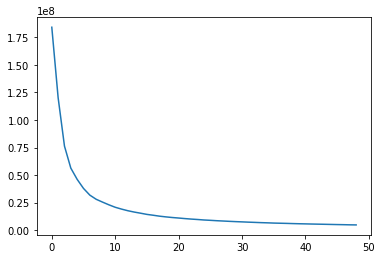

In [25]:
import matplotlib.pyplot as plt
plt.plot(z)
plt.show()

In [26]:
num_clusters=10
km=KMeans(n_clusters=num_clusters, init='k-means++',n_init=10, verbose=1)
km.fit(X_embedded)
clusters = km.labels_.tolist()
predict=km.predict(X_embedded)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 26341020.0
start iteration
done sorting
end inner loop
Iteration 1, inertia 24612958.0
start iteration
done sorting
end inner loop
Iteration 2, inertia 24072456.0
start iteration
done sorting
end inner loop
Iteration 3, inertia 23772790.0
start iteration
done sorting
end inner loop
Iteration 4, inertia 23580236.0
start iteration
done sorting
end inner loop
Iteration 5, inertia 23472728.0
start iteration
done sorting
end inner loop
Iteration 6, inertia 23409034.0
start iteration
done sorting
end inner loop
Iteration 7, inertia 23358886.0
start iteration
done sorting
end inner loop
Iteration 8, inertia 23330002.0
start iteration
done sorting
end inner loop
Iteration 9, inertia 23310942.0
start iteration
done sorting
end inner loop
Iteration 10, inertia 23292770.0
start iteration
done sorting
end inner loop
Iteration 11, inertia 23282228.0
start iteration
done sorting
end inner loop
Iteration 12, iner

end inner loop
Iteration 12, inertia 23207230.0
start iteration
done sorting
end inner loop
Iteration 13, inertia 23201900.0
start iteration
done sorting
end inner loop
Iteration 14, inertia 23198832.0
start iteration
done sorting
end inner loop
Iteration 15, inertia 23195888.0
start iteration
done sorting
end inner loop
Iteration 16, inertia 23194466.0
start iteration
done sorting
end inner loop
Iteration 17, inertia 23192406.0
start iteration
done sorting
end inner loop
Iteration 18, inertia 23191510.0
start iteration
done sorting
end inner loop
Iteration 19, inertia 23191120.0
start iteration
done sorting
end inner loop
Iteration 20, inertia 23191002.0
center shift 9.455117e-02 within tolerance 2.619445e-02
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 25011136.0
start iteration
done sorting
end inner loop
Iteration 1, inertia 23922298.0
start iteration
done sorting
end inner loop
Iteration 2, inertia 23480942.0
start iteration
done sorting

end inner loop
Iteration 21, inertia 23012644.0
center shift 1.457540e-01 within tolerance 2.619445e-02
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 26699336.0
start iteration
done sorting
end inner loop
Iteration 1, inertia 25114612.0
start iteration
done sorting
end inner loop
Iteration 2, inertia 24346116.0
start iteration
done sorting
end inner loop
Iteration 3, inertia 23934546.0
start iteration
done sorting
end inner loop
Iteration 4, inertia 23715866.0
start iteration
done sorting
end inner loop
Iteration 5, inertia 23593370.0
start iteration
done sorting
end inner loop
Iteration 6, inertia 23514102.0
start iteration
done sorting
end inner loop
Iteration 7, inertia 23441574.0
start iteration
done sorting
end inner loop
Iteration 8, inertia 23358378.0
start iteration
done sorting
end inner loop
Iteration 9, inertia 23292576.0
start iteration
done sorting
end inner loop
Iteration 10, inertia 23231494.0
start iteration
done sorting
end in

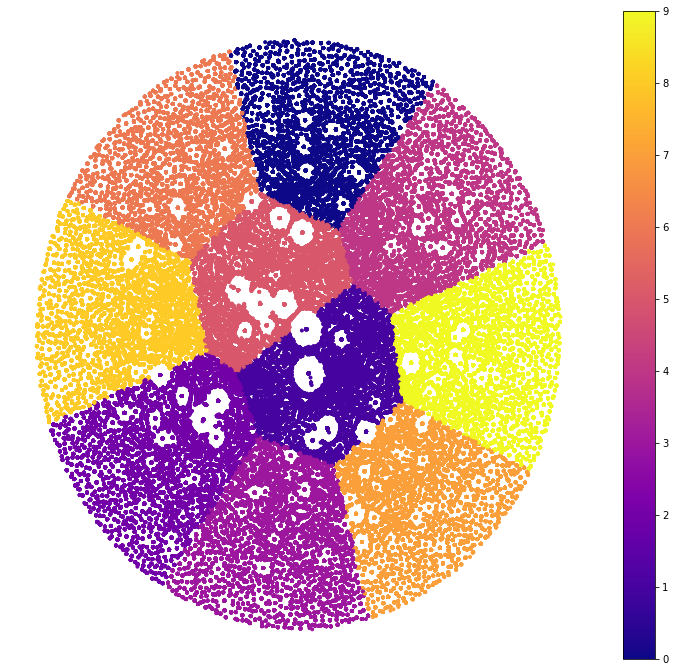

In [28]:
import matplotlib.pyplot as plt
#figure(figsize=(10, 5))
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
        c=clusters, cmap='plasma', marker=".")
plt.colorbar()
plt.show()

In [ ]:
cluster_map = pd.DataFrame()
cluster_map['y_train'] = y_train.index.values
cluster_map['LEAF_name'] = 
cluster_map['cluster'] = km.labels_

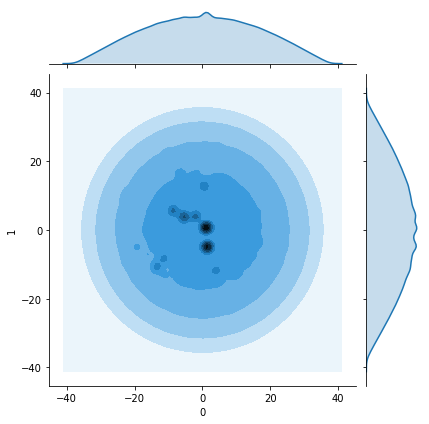

In [29]:
import seaborn as sns
data = pd.DataFrame(X_embedded)
x = data[0]
y = data[1]

sns.jointplot(x=x, y=y, data=data, kind="kde");
#data.head()